<a href="https://colab.research.google.com/github/injoon-pij/pytorch-learning/blob/master/pytorch_sequence_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Sequence Labeling

## Tagging

 * 입력 시퀀스 X에 대하여 레이블 시퀀스 y를 각각 부여하는 작업을 시퀀스 레이블링 작업(Sequence Labeling Task)이라고 합
 * 태깅 작업은 대표적인 시퀀스 레이블링 작업 
 * 태깅을 해야하는 단어 데이터를 X, 레이블에 해당되는 태깅 정보 데이터는 y라고 할 때 X와 y데이터의 쌍(pair)은 병렬 구조를 가짐

* 구축할 모델의 특징
 * RNN의 다-대-다(Many-to-Many) 모델
 * 앞뒤 시점의 입력을 모두 참고하는 양방향 RNN(Bidirectional RNN)을 사용
 * X와 y의 각 샘플의 길이가 같다

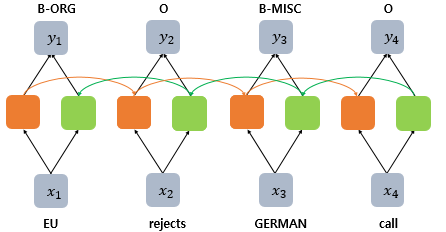

# 2) Pos Tagging by Bi-directional RNN

## 2.1 Data preprocessing

In [1]:
# setting
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy import data
from torchtext.legacy import datasets
import time
import random

# seed
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.1.1 Data Field

In [2]:
TEXT = data.Field(lower = True)
UD_TAGS = data.Field(unk_token = None)
PTB_TAGS = data.Field(unk_token = None)

fields = (("text", TEXT), ("udtags", UD_TAGS), ("ptbtags", PTB_TAGS))

### 2.1.2 Data Load

In [3]:
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

In [4]:
print(f"훈련 샘플의 개수 : {len(train_data)}")
print(f"검증 샘플의 개수 : {len(valid_data)}")
print(f"테스트 샘플의 개수 : {len(test_data)}")

훈련 샘플의 개수 : 12543
검증 샘플의 개수 : 2002
테스트 샘플의 개수 : 2077


In [5]:
# 데이터 확인
print(vars(train_data.examples[0])['text']) # 입력 시퀀스
print(vars(train_data.examples[0])['udtags']) # 레이블 시퀀스
print(vars(train_data.examples[0])['ptbtags']) # 레이블 시퀀스로 사용되지 않을 예정

['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']
['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']


### 2.1.3 Vocabulary

단어 집합 생성 시 사전 훈련된 워드 임베딩인 GloVe를 사용

In [6]:
# 최소 허용 빈도
MIN_FREQ = 5

# 사전 훈련된 워드 임베딩 GloVe 다운로드
TEXT.build_vocab(train_data, min_freq = MIN_FREQ, vectors = "glove.6B.100d")
UD_TAGS.build_vocab(train_data)
PTB_TAGS.build_vocab(train_data)

In [7]:
# 상위 빈도수 20개 단어
print(TEXT.vocab.freqs.most_common(20))

[('the', 9076), ('.', 8640), (',', 7021), ('to', 5137), ('and', 5002), ('a', 3782), ('of', 3622), ('i', 3379), ('in', 3112), ('is', 2239), ('you', 2156), ('that', 2036), ('it', 1850), ('for', 1842), ('-', 1426), ('have', 1359), ('"', 1296), ('on', 1273), ('was', 1244), ('with', 1216)]


In [8]:
print('단어집합의 크기 : {}'.format(len(TEXT.vocab.itos)))
print(TEXT.vocab.itos[:10])

단어집합의 크기 : 3921
['<unk>', '<pad>', 'the', '.', ',', 'to', 'and', 'a', 'of', 'i']


* TEXT.vocab.stoi : token-index list

* TEXT.vocab.itos : token-index dictionary

 * s = str, i = index

In [9]:
# 상위 빈도수 20개 태그 레이블
print(UD_TAGS.vocab.freqs.most_common())

[('NOUN', 34781), ('PUNCT', 23679), ('VERB', 23081), ('PRON', 18577), ('ADP', 17638), ('DET', 16285), ('PROPN', 12946), ('ADJ', 12477), ('AUX', 12343), ('ADV', 10548), ('CCONJ', 6707), ('PART', 5567), ('NUM', 3999), ('SCONJ', 3843), ('X', 847), ('INTJ', 688), ('SYM', 599)]


In [10]:
print('태그 레이블 단어집합의 크기 : {}'.format(len(UD_TAGS.vocab.itos)))
print(UD_TAGS.vocab.itos[:10])

태그 레이블 단어집합의 크기 : 18
['<pad>', 'NOUN', 'PUNCT', 'VERB', 'PRON', 'ADP', 'DET', 'PROPN', 'ADJ', 'AUX']


In [11]:
# 태그 레이블의 분포를 확인하는 함수
def tag_percentage(tag_counts):
    total_count = sum([count for tag, count in tag_counts])
    tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts]

    return tag_counts_percentages

In [12]:
print("Tag  Occurences Percentage\n")
for tag, count, percent in tag_percentage(UD_TAGS.vocab.freqs.most_common()):
    print(f"{tag}\t{count}\t{percent*100:4.1f}%")

Tag  Occurences Percentage

NOUN	34781	17.0%
PUNCT	23679	11.6%
VERB	23081	11.3%
PRON	18577	 9.1%
ADP	17638	 8.6%
DET	16285	 8.0%
PROPN	12946	 6.3%
ADJ	12477	 6.1%
AUX	12343	 6.0%
ADV	10548	 5.2%
CCONJ	6707	 3.3%
PART	5567	 2.7%
NUM	3999	 2.0%
SCONJ	3843	 1.9%
X	847	 0.4%
INTJ	688	 0.3%
SYM	599	 0.3%


### 2.1.4 DataLoader

In [13]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [14]:
# 데이터 확인
batch = next(iter(train_iterator))

In [15]:
print(batch)
print(batch.text.shape)
print(batch.text)


[torchtext.legacy.data.batch.Batch of size 64 from UDPOS]
	[.text]:[torch.cuda.LongTensor of size 46x64 (GPU 0)]
	[.udtags]:[torch.cuda.LongTensor of size 46x64 (GPU 0)]
	[.ptbtags]:[torch.cuda.LongTensor of size 46x64 (GPU 0)]
torch.Size([46, 64])
tensor([[ 732,  167,    2,  ...,    2,   59,  668],
        [  16,  196,  133,  ..., 2991,   46,    1],
        [   1,   29,   48,  ..., 1582,   12,    1],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')


앞서 Field를 정의했을 때, batch_first(default = False)를 True로 설정하지 않았기 때문에 배치크기가 데이터의 두번째 차원이 되었음 

## 2.2 Modeling

### 2.2.1 Define class

In [16]:
class RNNPOSTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout): 
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [sequence len, batch size]
        embedded = self.dropout(self.embedding(text))

        # embedded = [sequence len, batch size, emb dim] -> batch_fist = False
        outputs, (hidden, cell) = self.rnn(embedded)

        # output = [sequence len, batch size, hid dim * n directions]
        # hidden/cell = [n layers * n directions, batch size, hid dim]
        predictions = self.fc(self.dropout(outputs))

        # predictions = [sequence len, batch size, output dim]
        return predictions

In [17]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(UD_TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = RNNPOSTagger(vocab_size = INPUT_DIM, 
                     embedding_dim = EMBEDDING_DIM, 
                     hidden_dim = HIDDEN_DIM, 
                     output_dim = OUTPUT_DIM, 
                     n_layers = N_LAYERS, 
                     bidirectional = BIDIRECTIONAL, 
                     dropout = DROPOUT)

In [18]:
# 파라미터 개수 출력
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,027,510 trainable parameters


* torch.numel() : Returns the total number of elements in the input tensor.

### 2.2.2 Embedding Layer(Pretrained Vectors)

In [19]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([3921, 100])


* 단어 집합에 존재하는 총 3,921개의 단어에 대해서 100차원의 벡터로 임베딩되어 있음

In [20]:
# 임베딩 벡터값 copy하여 모델의 embedding layer에 연결
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1020,  0.7700,  0.1169,  ..., -0.1416, -0.1932, -0.4225],
        [-0.0263,  0.0179, -0.5016,  ..., -0.8688,  0.9409, -0.2882],
        [ 0.1519,  0.4712,  0.0895,  ..., -0.4702, -0.3127,  0.1078]])

* 첫번째 임베딩 벡터와 두번째 임베딩 벡터는 각각 <unk> 토큰과 <pad> 토큰
 * 만약 두 임베딩 벡터가 제로벡터가 아니라면 제로벡터로 변환해주어야 함

### 2.2.3 Optimizer/Cost Function

In [21]:
# optimizer
optimizer = optim.Adam(model.parameters())

# Cost Function
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX).to(device)

* 레이블 시퀀스에 속해있는 패딩 토큰은 비용 함수의 연산에 포함시키지 않도록 이를 무시하라고 지정함
 * ```nn.CrossEntropyLoss(ignore_index =)``` : Specifies a target value that is ignored and does not contribute to the input gradient

In [22]:
# 출력(예측값) 크기 확인
model = model.to(device)
prediction = model(batch.text)
print(prediction.shape) # (시퀀스 길이 × 배치 크기 × 레이블 단어집합의 크기)

prediction = prediction.view(-1, prediction.shape[-1])
print(prediction.shape)

torch.Size([46, 64, 18])
torch.Size([2944, 18])


In [23]:
# 해당 배치에 대한 레이블 데이터 크기 확인
print(batch.udtags.shape)
print(batch.udtags.view(-1).shape)

torch.Size([46, 64])
torch.Size([2944])


In [24]:
# iterator 재설정
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

### 2.2.4 Train & Evaluate

In [25]:
def categorical_accuracy(preds, y, tag_pad_idx, device):
    """
    미니 배치에 대한 정확도 출력
    """

    # preds [sequence len * batch size, output dim] -> max_preds [sequence len * batch size, 1]
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability

    # y [sequence len * batch size]
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(dim = 1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

* ```nonzero()``` : 입력 텐서값들 중 값이 0이 아닌 데이터들의 인덱스를 반환

```python
torch.Tensor([1,2,3,0,0]).nonzero()

>>> tensor([[0],
            [1],
            [2]])

torch.Tensor([[1,2,3,0,0],
             [0,0,0,2,3]]).nonzero()

>>> tensor([[0, 0],
            [0, 1],
            [0, 2],
            [1, 3],
            [1, 4]])
```

* ```squeeze(dim = 1)``` : 지정한 차원에 대해서만 squeeze 연산을 행함. 만약 차원의 크기가 1인 차원이 있다고 하더라도, 지정한 차원이 아니면 squeeze 연산이 실행되지 않음

```python
torch.tensor([[1],
              [2],
              [3]]).squeeze(dim = 0)

>>> tensor([[1],
            [2],
            [3]])

torch.tensor([[1],
              [2],
              [3]]).squeeze(dim = 1)

>>> tensor([1, 2, 3])
```

#### def categorical_accuracy() 이해

함수의 이해를 돕기 위해 예시 데이터를 뽑아서 확인 

In [26]:
# 예시 데이터
batch = next(iter(train_iterator))
tag_pad_idx = 0

model = model.to(device)
prediction = model(batch.text)
tag = batch.udtags

# Flatten
prediction = prediction.view(-1, prediction.shape[-1]) #prediction = [sequence len * batch size, output dim]
tag = tag.view(-1) # tag = [sequence len * batch_size]

* max_preds = preds.argmax(dim = 1, keepdim = True) 확인
 * ```keepdim = True``` : 입력 데이터 차원이 유지됨

In [27]:
max_pred = prediction.argmax(dim = 1, keepdim = True)

# 입력 데이터 차원이 유지된 것을 확인
print('prediction 크기 : {}'.format(prediction.shape))
print('max_pred 크기 : {}'.format(max_pred.shape))
print('tag 크기 : {}'.format(tag.shape))

prediction 크기 : torch.Size([2944, 18])
max_pred 크기 : torch.Size([2944, 1])
tag 크기 : torch.Size([2944])


* non_pad_elements = (y != tag_pad_idx).nonzero() 확인
 * y의 데이터들 중 값이 tag_pad_idx(= 0)와 다른 데이터들의 인덱스들을 차례대로 반환

In [28]:
non_pad_elements = (tag != tag_pad_idx).nonzero()

# non_pad_elements의 최종차원(1065)과, 최종차원의 인덱스 데이터(2847)가 다른 것을 확인
print('non_pad_elements[-5:-1] : {}'.format(non_pad_elements[-5:-1]))
print('non_pad_elements 크기 : {}'.format(non_pad_elements.shape))

non_pad_elements[-5:-1] : tensor([[2655],
        [2719],
        [2783],
        [2847]], device='cuda:0')
non_pad_elements 크기 : torch.Size([1065, 1])


* correct = max_preds[non_pad_elements].squeeze(dim = 1).eq(y[non_pad_elements]) 확인
 * 앞서 구한 인덱스 데이터를 각각 max_preds와 y의 데이터 인덱싱에 사용하여 두 데이터의 형상을 같게 만든 뒤 비교

In [29]:
# max_pred[non_pad_elements]가 한 차원 더 많아 데이터 크기가 다르므로, squeeze로 줄여줘야 함
print('max_pred[non_pad_elements] 크기 : {}'.format(max_pred[non_pad_elements].shape))
print('tag[non_pad_elements] 크기 : {}'.format(tag[non_pad_elements].shape))

correct = max_pred[non_pad_elements].squeeze(dim = 1).eq(tag[non_pad_elements])
print('correct 크기 : {}'.format(correct.shape))

max_pred[non_pad_elements] 크기 : torch.Size([1065, 1, 1])
tag[non_pad_elements] 크기 : torch.Size([1065, 1])
correct 크기 : torch.Size([1065, 1])


In [30]:
# iterator 재설정
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

---

In [31]:
def train(model, iterator, optimizer, criterion, tag_pad_idx, device):

    epoch_loss = 0
    epoch_acc = 0

    model = model.to(device)
    model.train()

    for batch in iterator:

        text = batch.text
        tags = batch.udtags

        optimizer.zero_grad()

        #text = [sequence len, batch size]     
        predictions = model(text)

        #predictions = [sequence len, batch size, output dim]
        #tags = [sequence len, batch size]
        predictions = predictions.view(-1, predictions.shape[-1]) # #predictions = [sequence len * batch size, output dim]
        tags = tags.view(-1) # tags = [sequence len * batch_size]

        #predictions = [sequence len * batch size, output dim]
        #tags = [sequence len * batch size]
        loss = criterion(predictions, tags)

        acc = categorical_accuracy(predictions, tags, tag_pad_idx, device)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion, tag_pad_idx, device):

    epoch_loss = 0
    epoch_acc = 0

    model = model.to(device)
    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text = batch.text
            tags = batch.udtags

            predictions = model(text)

            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            loss = criterion(predictions, tags)

            acc = categorical_accuracy(predictions, tags, tag_pad_idx, device)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 1.107 | Train Acc: 65.47%
	 Val. Loss: 0.663 |  Val. Acc: 80.06%
Epoch: 02
	Train Loss: 0.386 | Train Acc: 87.77%
	 Val. Loss: 0.533 |  Val. Acc: 83.53%
Epoch: 03
	Train Loss: 0.303 | Train Acc: 90.18%
	 Val. Loss: 0.489 |  Val. Acc: 84.55%
Epoch: 04
	Train Loss: 0.264 | Train Acc: 91.36%
	 Val. Loss: 0.466 |  Val. Acc: 85.20%
Epoch: 05
	Train Loss: 0.237 | Train Acc: 92.20%
	 Val. Loss: 0.449 |  Val. Acc: 85.60%
Epoch: 06
	Train Loss: 0.219 | Train Acc: 92.78%
	 Val. Loss: 0.436 |  Val. Acc: 85.57%
Epoch: 07
	Train Loss: 0.204 | Train Acc: 93.31%
	 Val. Loss: 0.428 |  Val. Acc: 85.88%
Epoch: 08
	Train Loss: 0.191 | Train Acc: 93.71%
	 Val. Loss: 0.411 |  Val. Acc: 86.39%
Epoch: 09
	Train Loss: 0.180 | Train Acc: 94.03%
	 Val. Loss: 0.413 |  Val. Acc: 86.44%
Epoch: 10
	Train Loss: 0.170 | Train Acc: 94.35%
	 Val. Loss: 0.417 |  Val. Acc: 86.44%
